In [1]:
import matplotlib as mpl #画图用的库
import matplotlib.pyplot as plt
#下面这一句是为了可以在notebook中画图
%matplotlib inline
import numpy as np
import sklearn   #机器学习算法库
import pandas as pd #处理数据的库   
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras   #使用tensorflow中的keras
#import keras #单纯的使用keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, sklearn, pd, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
sklearn 0.21.3
pandas 0.25.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
fashion_mnist = keras.datasets.fashion_mnist # 该数据集是黑白服装数据集
#拆分训练集和测试集
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
#将训练集拆分为训练集和验证集
#训练集共6万张图片，我们将前5000张作为验证集，后面所有的做训练集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_train[0].dtype)
print(x_train[0]) # 是一个数据矩阵 28*28, 矩阵中的每一个数值都是uint8类型
print(y_train[0]) #这里的y值均为数字编码，非向量，所以后面定义模型损失函数为 sparse_categorical_crossentropy
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  44 127 182 185 161 120  55
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42 198 251 255 251 249 247 255 252
  214 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 233 252 237 239 234 237 235 237 237
  254 227   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   2   0   0  16 210 225 215 175 217 216 193 196 226
  221 209  50   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   0 199 229 232 230 245 204 219 253 245 207 194
  223 231 236 235   0   0   3   0   0   0]
 [  0   0   0   0   1   0 137 235 204 209 201 209 234 190 234 218 215 238
  239 204 189 224 154   0   0   0   0   0]
 [  0   0   0   0   0   0 194 201 200 209 202 193 205 194 183 218 231 197
  172 181 193 205 199   0   0   0   0   0]
 [  0   0   0   0   0   3 212 203 188 189 196 198 198 201 

In [4]:
#在图像分类领域我们提升准确率的手段 归一化：
# 1.对训练数据进行归一化 2. 批归一化

# x = (x - u)/std  u为均值，std为方差
from sklearn.preprocessing import StandardScaler #使用sklearn中的StandardScaler实现训练数据归一化

scaler = StandardScaler()

#fit_transform:得到方差、均值、最大最小值然后数据进行归一化操作
#https://blog.csdn.net/youhuakongzhi/article/details/90519801
#x_train：先转为float32用于做除法，x_train本身为三维矩阵[None,28,28]，因为fit_transform要求二维数据所以需要转换为[None, 784]，再转回四维矩阵
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
#是因为在trainData的时候，已经使用fit()得到了整体的指标（均值，方差等）并被保存起来了后面验证集测试集可以使用，所以在测试集上直接transform()，使用之前的指标，
#如果在测试集上再进行fit()，由于两次的数据不一样，导致得到不同的指标，会使预测发生偏差，因为模型是针对之前的数据fit()出来
#的标准来训练的，而现在的数据是新的标准，会导致预测的不准确
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
#reshape(-1,1)表示（任意行，1列），这里个人认为设置里面什么参数影响不大，只要是转换为二维即可，反正最终要转换为三/四 维使用


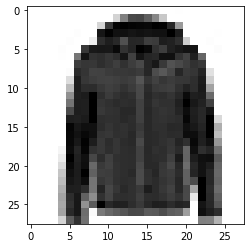

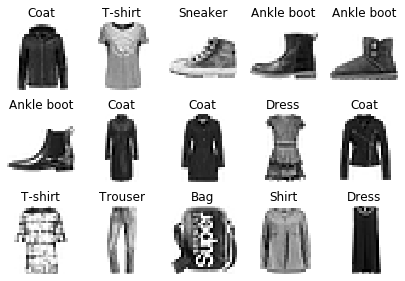

In [5]:
#展示一下数据集中的图片

###展示单张图片
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary") #cmap:将标准化标量映射为颜色, binary代表白底黑字
    plt.show()
show_single_image(x_train[0])

###展示图片组
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6)) #.figure 在plt中绘制一张图片
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1) # 创建单个子图
            plt.imshow(x_data[index], cmap="binary", interpolation='nearest')
            plt.axis('off') #取消坐标系
            plt.title(class_names[y_data[index]]) #标题
    plt.show()
    
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

In [6]:
#tf.keras.models.Sequential()

model = keras.models.Sequential()

'''
#使用深度卷积网络实现

model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation="selu"))# 激活函数selu自带数据归一化功能，在一定程度上也能缓解梯度消失问题

'''
#使用卷积神经网络实现
#激活函数这里使用了自带批归一化的selu函数来代替使用relu激活函数
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation="selu",input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation="selu"))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation="selu"))
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation="selu"))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation="selu"))
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation="selu"))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation="selu"))


#softmax层输出
model.add(keras.layers.Dense(10,activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam", #optimizer="sgd", 优化算法一般来说我们无脑用adam即可
             metrics=["accuracy"])

#查看上面建立的模型架构信息
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [7]:
#Tensorflow中的callback用于模型训练过程中的一些监听操作，常用的callback类型如下三类：
#Tensorboard 可视化Tensorboard
#earlystopping 当loss函数不能再优化时停止训练,这样可以截取到最优的模型参数
#ModelCheckpoint 每次epoch之后就保存模型

#当前目录下新建一个callbacks文件夹并在里面创建一个h5模型文件
import shutil
logdir='./callbacks_cnn'

if os.path.exists(logdir):
    shutil.rmtree(logdir) #先强制删除该文件夹，后面再新建
os.mkdir(logdir)
        
output_model_file=os.path.join(logdir,"fashion_mnist_model.h5")#在logdir中创建一个模型文件.h5

#定义一个callbacks数组
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),#这里第二个参数表示仅保存最好的那个模型
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]

'''
#在未做数据集归一化时这里直接将x_train三维矩阵转换为四维
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
'''

#fit用于训练
history=model.fit(x_train_scaled, y_train, epochs=10, #epochs用于遍历训练集次数
                  validation_data=(x_valid_scaled,y_valid),#加入验证集，每隔一段时间就对验证集进行验证
                  callbacks=callbacks)
'''
history=model.fit(x_train, y_train, epochs=10, #epochs用于遍历训练集次数
                  validation_data=(x_valid,y_valid),#加入验证集，每隔一段时间就对验证集进行验证
                  callbacks=callbacks)
'''

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 17s 301us/sample - loss: 0.4269 - accuracy: 0.8475 - val_loss: 0.3261 - val_accuracy: 0.8834
Epoch 2/10
55000/55000 [==============================] - 14s 256us/sample - loss: 0.3159 - accuracy: 0.8858 - val_loss: 0.3003 - val_accuracy: 0.8934
Epoch 3/10
55000/55000 [==============================] - 14s 253us/sample - loss: 0.2813 - accuracy: 0.8986 - val_loss: 0.2988 - val_accuracy: 0.8918
Epoch 4/10
55000/55000 [==============================] - 14s 252us/sample - loss: 0.2640 - accuracy: 0.9044 - val_loss: 0.2744 - val_accuracy: 0.9034
Epoch 5/10
55000/55000 [==============================] - 14s 257us/sample - loss: 0.2396 - accuracy: 0.9139 - val_loss: 0.2707 - val_accuracy: 0.9028
Epoch 6/10
55000/55000 [==============================] - 14s 256us/sample - loss: 0.2215 - accuracy: 0.9215 - val_loss: 0.2849 - val_accuracy: 0.9060
Epoch 7/10
55000/55000 [=====================

'\nhistory=model.fit(x_train, y_train, epochs=10, #epochs用于遍历训练集次数\n                  validation_data=(x_valid,y_valid),#加入验证集，每隔一段时间就对验证集进行验证\n                  callbacks=callbacks)\n'

In [8]:
#history记录的是所有训练过程中的一些指标数据
history.history

{'loss': [0.426871630898389,
  0.31593207191012124,
  0.2812929238070141,
  0.2639954809763215,
  0.23960529286129909,
  0.22146498423814773,
  0.21093398170660843,
  0.2143185702254149,
  0.183168968540701,
  0.18230817787538875],
 'accuracy': [0.84752727,
  0.88583636,
  0.89861816,
  0.90443635,
  0.91394544,
  0.92154545,
  0.9240182,
  0.9249273,
  0.93436366,
  0.93536365],
 'val_loss': [0.32608932976722715,
  0.3003350764513016,
  0.29880118045508863,
  0.2744145386859775,
  0.27074510134607555,
  0.28493240386396645,
  0.2693626198470592,
  0.25640695583168416,
  0.25856374667584897,
  0.2906165848374367],
 'val_accuracy': [0.8834,
  0.8934,
  0.8918,
  0.9034,
  0.9028,
  0.906,
  0.9082,
  0.9158,
  0.909,
  0.9078]}

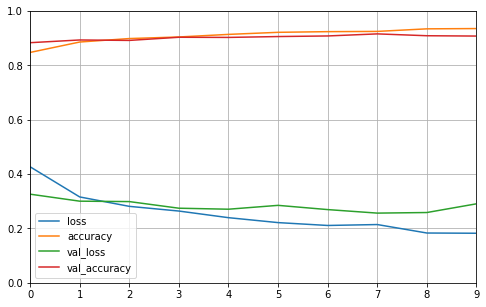

In [9]:
#将上面history中的数据指标用一张图来表示
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5)) #设置图的大小
    plt.grid(True) #显示网格
    plt.gca().set_ylim(0,1) #设置y轴范围
    plt.show()
plot_learning_curves(history)


In [10]:
#测试集上进行测试评估一下
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3334893117487431, 0.9018]